# MVSA - multiple
last version 0425

In [1]:
import tensorflow as tf

import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

import sys
sys.path.append('./cs16')
import cs16.prep as prep16
import cs16.plot as plot16
import cs16.build as build16
imagesize = 64

import pandas as pd

import cs16.prep as prep16
import cs16.plot as plot16
import cv2
import numpy as np
import pandas as pd
import os
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
max_words=10000
max_len=100
imagesize =64


#data_type = input("Enter '1. single' for single dataset or '2. multi' for multiple dataset: ")
data_type = '2'
if data_type == '1':
    file_path = 'single.txt'
    folder_path = './data/MVSA/single/'
elif data_type == '2':
    file_path = 'multi.txt'
    folder_path = './data/MVSA/multiple/'
else:
    print("Invalid input. Please enter either 'single' or 'multi'.")
    exit()

df = pd.read_csv(file_path, index_col=None, encoding='ISO-8859-1')

In [3]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import pandas as pd
import matplotlib.pyplot as plt

# Download stopwords and punkt tokenizer if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Define a function to preprocess text
def nlp_text(text):
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs using regex
    text = re.sub(r'http\S+', '', text)
    
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize text into individual words
    words = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    
    # Stem words using Porter Stemmer
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join words back into a single string
    text = ' '.join(words)
    
    return text

# Apply the preprocess_text function to the 'tweet' column of the dataframe
df['tweet'] = df['tweet'].apply(nlp_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ausco\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
import xgboost as xgb
import time
# stopwatch
def some_function():
    result = 0
    for i in range(1000000):
        result += i
    return result

In [5]:
X_text, y_text = prep16.preprocess_text(df)
X_train_text, X_val_text, X_test_text, \
y_train_text, y_val_text, y_test_text = prep16.split_data(X_text, y_text, random_state=42)

X_polar, y_polar = prep16.preprocess_text(df,label = 'polarity')
X_train_polar, X_val_polar, X_test_polar, \
y_train_polar, y_val_polar, y_test_polar = prep16.split_data(X_polar, y_polar, random_state=42)

image_data_s, image_label_s = prep16.preprocess_images(df, folder_path, imagesize)
y_s = to_categorical(image_label_s, num_classes=3)

X_train_image, X_val_image, X_test_image, \
y_train_image, y_val_image, y_test_image= prep16.split_data(image_data_s, y_s, random_state=42)

y_train = to_categorical(y_train_polar, num_classes=3)
y_val =to_categorical(y_val_polar, num_classes=3)
y_test =to_categorical(y_test_polar, num_classes=3)
file_path

'multi.txt'

# DPF

### TOP-K+ ADAPTIVE Epsilon
（Last use: 2025/05/09）

In [8]:
import numpy as np
from sklearn.ensemble import ExtraTreesClassifier
def dynamic_weight_topk_adaptive(prob1, prob2, beta=0.1, topk=2, delta=1e-4):
    """
    Calculate dynamic weights for two modalities using Top-k Approximate Rényi-2 entropy
    with adaptive epsilon regularization for numerical stability.

    Args:
        prob1 (ndarray): Text modality predicted probabilities, shape (n_samples, n_classes)
        prob2 (ndarray): Image modality predicted probabilities, shape (n_samples, n_classes)
        beta (float): Temperature scaling factor.
        topk (int): Number of top probabilities to consider for entropy approximation.
        delta (float): Scaling factor for adaptive epsilon, relative to maximum squared probability.

    Returns:
        weights (ndarray): Normalized modality weights, shape (n_samples, 2)
    """
    # Select Top-k largest probabilities
    topk_prob1 = np.sort(prob1, axis=1)[:, -topk:]  # shape: (n_samples, topk)
    topk_prob2 = np.sort(prob2, axis=1)[:, -topk:]

    # Compute adaptive epsilon based on maximum p² in Top-k
    max_p2_text = np.max(topk_prob1**2, axis=1, keepdims=True)  # shape: (n_samples, 1)
    max_p2_image = np.max(topk_prob2**2, axis=1, keepdims=True)

    adaptive_eps_text = delta * max_p2_text  # epsilon for text modality
    adaptive_eps_image = delta * max_p2_image  # epsilon for image modality

    # Compute energy (negative log collision probability)
    energy_text = -np.log(np.sum(topk_prob1**2, axis=1, keepdims=True) + adaptive_eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob2**2, axis=1, keepdims=True) + adaptive_eps_image).flatten()

    # Compute normalized weights via Gibbs-style softmax
    energies = np.vstack([energy_text, energy_image]).T  # shape: (n_samples, 2)
    weights = np.exp(-beta * energies)
    weights /= np.sum(weights, axis=1, keepdims=True)

    return weights

def enhanced_dynamic_fusion_topk_adaptive(probs_text, probs_image, beta=0.1, topk=2, delta=1e-4):
    """
    Perform enhanced fusion by dynamically weighting two modalities and concatenating
    their weighted outputs, preserving modality-specific information.

    Args:
        probs_text (ndarray): Text modality predicted probabilities, shape (n_samples, n_classes)
        probs_image (ndarray): Image modality predicted probabilities, shape (n_samples, n_classes)
        beta (float): Temperature scaling factor.
        topk (int): Top-k approximation size.
        delta (float): Adaptive epsilon scaling factor.

    Returns:
        enhanced_fused_probs (ndarray): Concatenated weighted probability vectors, shape (n_samples, 2*n_classes)
    """
    weights = dynamic_weight_topk_adaptive(probs_text, probs_image, beta, topk, delta)
    fused_text = weights[:, 0:1] * probs_text  # weight applied to text probabilities
    fused_image = weights[:, 1:2] * probs_image  # weight applied to image probabilities
    enhanced_fused_probs = np.concatenate([fused_text, fused_image], axis=1)
    return enhanced_fused_probs


# MAIN
(last use:2025/05/09)

In [9]:

start_time = time.time()
#------------------------------------------------------------

########################################
# 1. one-hot 
########################################
y_train_int = np.argmax(y_train, axis=1)
y_val_int   = np.argmax(y_val,   axis=1)
y_test_int  = np.argmax(y_test,  axis=1)

########################################
# 2. Text Modality：Original RandomForest-> ExtraTree，Prob Vector(3-dim)
########################################
rf_text = ExtraTreesClassifier(n_estimators=100, random_state=42)

rf_text.fit(X_train_text, y_train_int)

# Each sample will get [p_neg, p_neu, p_pos]
train_probs_text = rf_text.predict_proba(X_train_text)  # shape -> (n_train, 3)
val_probs_text   = rf_text.predict_proba(X_val_text)    # shape -> (n_val,   3)
test_probs_text  = rf_text.predict_proba(X_test_text)   # shape -> (n_test,  3)

########################################
# 3. Image Modality：
########################################
X_train_img_flat = X_train_image.reshape(X_train_image.shape[0], -1)
X_val_img_flat   = X_val_image.reshape(X_val_image.shape[0],   -1)
X_test_img_flat  = X_test_image.reshape(X_test_image.shape[0], -1)

rf_image = ExtraTreesClassifier(
    n_estimators=100,
    max_depth=12,#12
    min_samples_leaf=6, #6
    max_features='sqrt', #'sqrt'
    class_weight='balanced',#'balanced'
    random_state=42,
    bootstrap=True # 
)
#ExtraTreesClassifier(n_estimators=100, max_features='sqrt',min_samples_leaf=6,bootstrap=True, random_state=42)
rf_image.fit(X_train_img_flat, y_train_int)

train_probs_image = rf_image.predict_proba(X_train_img_flat)  # (n_train, 3)
val_probs_image   = rf_image.predict_proba(X_val_img_flat)    # (n_val,   3)
test_probs_image  = rf_image.predict_proba(X_test_img_flat)   # (n_test,  3)

########################################
# 4. Global Fusion：Text(3) + Image(3) -> 6 Dimension
########################################
beta = 1
topk=2
delta =1e-2

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(350, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# 测试集
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))

#------------------------------------------------------------

end_time = time.time()
elapsed_time = end_time - start_time

# TIME TAKEN
print(f"Time Executed ===============>：{elapsed_time:.4f} Sec")

Dynamic Fusion Feature shape (train): (15568, 6)


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Test Accuracy: 0.7255909558067831
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.1864    0.0433    0.0703       254
     neutral     0.7657    0.9418    0.8447      1461
    positive     0.2778    0.1082    0.1558       231

    accuracy                         0.7256      1946
   macro avg     0.4100    0.3645    0.3569      1946
weighted avg     0.6322    0.7256    0.6618      1946

Function: 499999500000
Time Executed ===============>：26.3309 Sec


In [101]:
# # 4. Global Fusion：Combine Text(3) + Image(3) -> 6 Dimensions
########################################
beta = 3
topk=2
delta =1e-4

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(300, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# TEST
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))


Dynamic Fusion Feature shape (train): (15568, 6)


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Test Accuracy: 0.7410071942446043
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.1667    0.0394    0.0637       254
     neutral     0.7668    0.9630    0.8538      1461
    positive     0.4902    0.1082    0.1773       231

    accuracy                         0.7410      1946
   macro avg     0.4745    0.3702    0.3649      1946
weighted avg     0.6556    0.7410    0.6703      1946



# delta =0 （No Regularzation）

In [102]:
# # 4. Global Fusion：Combine Text(3) + Image(3) -> 6 Dimensions
########################################
beta = 1
topk=2
delta =0

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(300, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# 测试集
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))


Dynamic Fusion Feature shape (train): (15568, 6)


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Test Accuracy: 0.725077081192189
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.1667    0.0394    0.0637       254
     neutral     0.7663    0.9405    0.8445      1461
    positive     0.2903    0.1169    0.1667       231

    accuracy                         0.7251      1946
   macro avg     0.4078    0.3656    0.3583      1946
weighted avg     0.6315    0.7251    0.6621      1946



# beta = 0 （No Dynamic Weighting）

In [103]:
########################################
# 4. Global Fusion：Combine Text(3) + Image(3) -> 6 Dimensions
########################################
beta = 0
topk=2
delta =1e-2

# 4. Dynamic Fusion
X_train_global = enhanced_dynamic_fusion_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
X_val_global   = enhanced_dynamic_fusion_topk_adaptive(val_probs_text,   val_probs_image, beta, topk, delta)
X_test_global  = enhanced_dynamic_fusion_topk_adaptive(test_probs_text,  test_probs_image, beta, topk, delta)
print("Dynamic Fusion Feature shape (train):", X_train_global.shape)
# 5. Global Classifier
global_clf = xgb.XGBClassifier(350, max_depth=5, random_state=42)
global_clf.fit(X_train_global, y_train_int)

# 测试集
test_pred = global_clf.predict(X_test_global)
print("Test Accuracy:", accuracy_score(y_test_int, test_pred))
print("Test Classification Report:")
print(classification_report(y_test_int, test_pred,
                            digits=4,
                            target_names=['negative','neutral','positive']))


Dynamic Fusion Feature shape (train): (15568, 6)


C:\Users\ausco\anaconda3\lib\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


Test Accuracy: 0.7317574511819116
Test Classification Report:
              precision    recall  f1-score   support

    negative     0.1972    0.0551    0.0862       254
     neutral     0.7691    0.9487    0.8495      1461
    positive     0.3288    0.1039    0.1579       231

    accuracy                         0.7318      1946
   macro avg     0.4317    0.3692    0.3645      1946
weighted avg     0.6422    0.7318    0.6678      1946



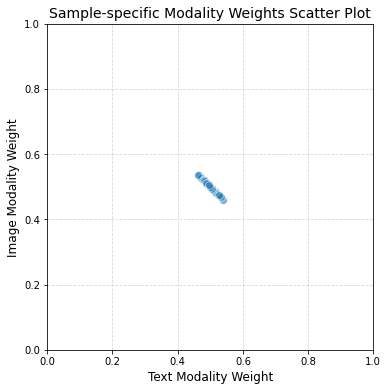

In [199]:
import matplotlib.pyplot as plt

def plot_modality_weights_scatter(weights):
    plt.figure(figsize=(8, 6))
    plt.scatter(weights[:, 0], weights[:, 1], alpha=0.6, edgecolors='w', s=60)
    plt.title("Sample-specific Modality Weights Scatter Plot", fontsize=14)
    plt.xlabel("Text Modality Weight", fontsize=12)
    plt.ylabel("Image Modality Weight", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# plot_modality_weights_scatter(weights)

wx = dynamic_weight_topk_adaptive(train_probs_text, train_probs_image, beta, topk, delta)
plot_modality_weights_scatter(wx)

In [197]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假設已經有：
# weights: numpy array of shape (n_samples, 2), 每列是 [weight_text, weight_image]
# labels: (optional) ground truth labels for coloring (n_samples, )

def plot_dpf_scatter(weights, labels=None):
    w_text = weights[:, 0]
    w_image = weights[:, 1]

    plt.figure(figsize=(8, 6))
    if labels is not None:
        unique_labels = np.unique(labels)
        palette = sns.color_palette("hsv", len(unique_labels))
        for i, ul in enumerate(unique_labels):
            idx = labels == ul
            plt.scatter(w_text[idx], w_image[idx], label=f"Class {ul}", alpha=0.6, s=40, color=palette[i])
        plt.legend()
    else:
        plt.scatter(w_text, w_image, alpha=0.6, s=40, color='steelblue')

    plt.xlabel('Text modality weight')
    plt.ylabel('Image modality weight')
    plt.title('DPF Sample-specific Modality Weights Scatter Plot')
    plt.grid(True)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()


# weights = dynamic_weight_topk_adaptive(train_probs_text, train_probs_image, beta=0.1, topk=2, delta=1e-4)
# labels = y_train
# plot_dpf_scatter(weights, labels)


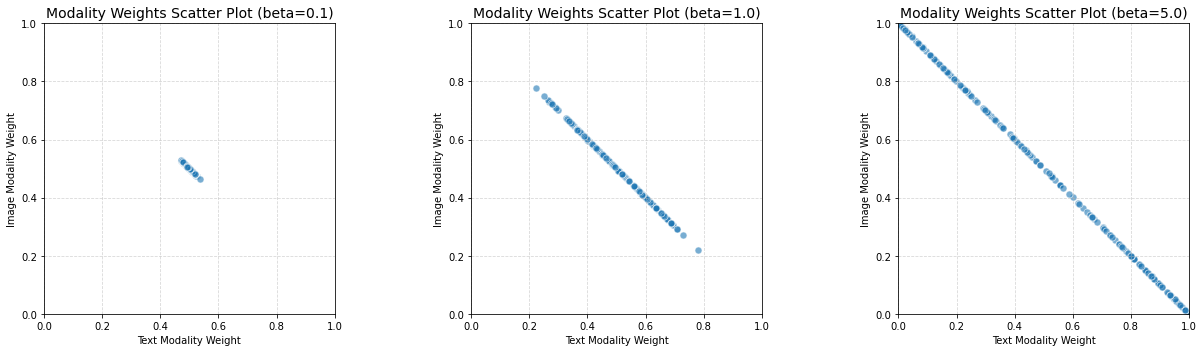

In [200]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_weights(beta, n_samples=200):
    #  (n_samples, n_classes=5)
    probs_text = np.random.dirichlet(np.ones(5), size=n_samples)
    probs_image = np.random.dirichlet(np.ones(5), size=n_samples)

    # Top-k = 2
    topk = 2
    delta = 1e-4

    # Top-k Appr
    topk_prob_text = np.sort(probs_text, axis=1)[:, -topk:]
    topk_prob_image = np.sort(probs_image, axis=1)[:, -topk:]

    # adaptive epsilon
    adaptive_eps_text = delta * np.max(topk_prob_text**2, axis=1, keepdims=True)
    adaptive_eps_image = delta * np.max(topk_prob_image**2, axis=1, keepdims=True)

    # energy Calcuation
    energy_text = -np.log(np.sum(topk_prob_text**2, axis=1, keepdims=True) + adaptive_eps_text).flatten()
    energy_image = -np.log(np.sum(topk_prob_image**2, axis=1, keepdims=True) + adaptive_eps_image).flatten()

    # Gibbs softmax-> Weighting
    energies = np.vstack([energy_text, energy_image]).T
    weights = np.exp(-beta * energies)
    weights /= np.sum(weights, axis=1, keepdims=True)

    return weights

# Dot graph
def plot_weights_scatter(weights, beta):
    plt.scatter(weights[:, 0], weights[:, 1], alpha=0.6, edgecolors='w', s=50)
    plt.title(f"Modality Weights Scatter Plot (beta={beta})", fontsize=14)
    plt.xlabel("Text Modality Weight")
    plt.ylabel("Image Modality Weight")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.gca().set_aspect('equal', adjustable='box')

betas = [0.1, 1.0, 5.0]
plt.figure(figsize=(18, 5))
for i, beta in enumerate(betas):
    plt.subplot(1, 3, i+1)
    w = simulate_weights(beta)
    plot_weights_scatter(w, beta)
plt.tight_layout()
plt.show()
